In [1]:
! pip3 install pyro-ppl 
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 678 kB 7.2 MB/s 
Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive")
files = os.listdir("./")
# print(files)
if "Results" not in files:
  os.mkdir("./Results")
!ls Results/

250_100_True			 250_500_True_simple_model_False_try_num_1
250_200_True			 250_500_True_simple_model_True
250_500_True			 250_500_True_simple_model_True_try_num_1
250_500_True_simple_model_False


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
import torch.nn as nn
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import bernoulli, binom
from sklearn import linear_model

from numpy import asarray
from numpy import savetxt

np.random.seed(33)

try_num = 1

# Size

n = 250
d = 500
# K = 100
p = 0.5


REP = 30
total_beta_sample = 20

num_epochs = 500
EPSILON = 1
lambda_val = 0.5
BATCH_SIZE = 32


first = True
simple_model = True

#Genarating Genotypes

# toy_genotypes = np.random.binomial(2, p, (n * 3, d))
# np.random.shuffle(toy_genotypes)


toy_genotypes = binom.rvs(2, p, size=(n * 3, d))
np.random.shuffle(toy_genotypes)

print(toy_genotypes.shape)

print(np.mean(toy_genotypes))
print(np.var(toy_genotypes))



RES_DICT = {'REP': REP, 'BATCH_SIZE': BATCH_SIZE}


(750, 500)
1.000856
0.5000446005973331


In [4]:
files = os.listdir("./Results")
save_file_name = str(n) + '_' + str(d) + '_' + str(first) + '_simple_model_' + str(simple_model) + '_try_num_' + str(try_num) 

if save_file_name not in files:
  os.mkdir("./Results/" + save_file_name)

os.chdir("Results/" + save_file_name)
!ls
!rm *.*
!ls

best_modedl.pt		  phenotypes_dist.pdf		train_genotypes.csv
betas.csv		  phenotypes_dist_together.pdf	train_phenotypes.csv
linear_model_res.pdf	  test_genotypes.csv		val_genotypes.csv
phenotypes_dist_cont.pdf  test_phenotypes.csv		val_phenotypes.csv


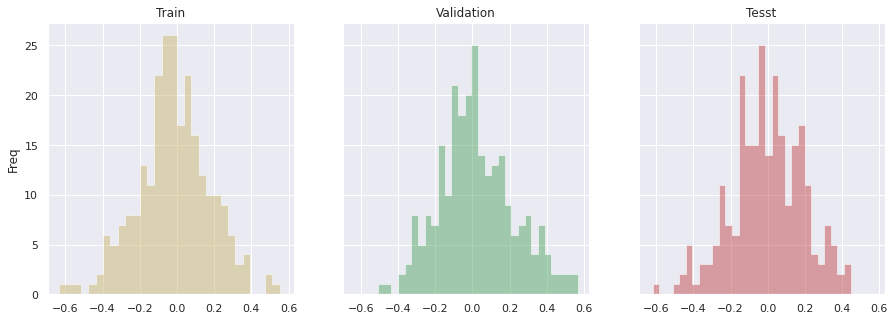

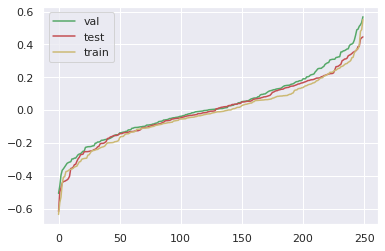

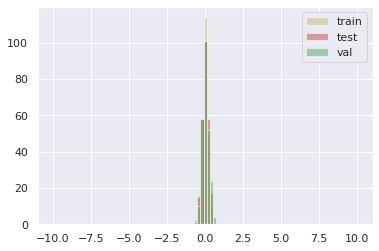

0.04569847156694837 validation
6.942410690845997e-07 train
0.04254246017894928 test



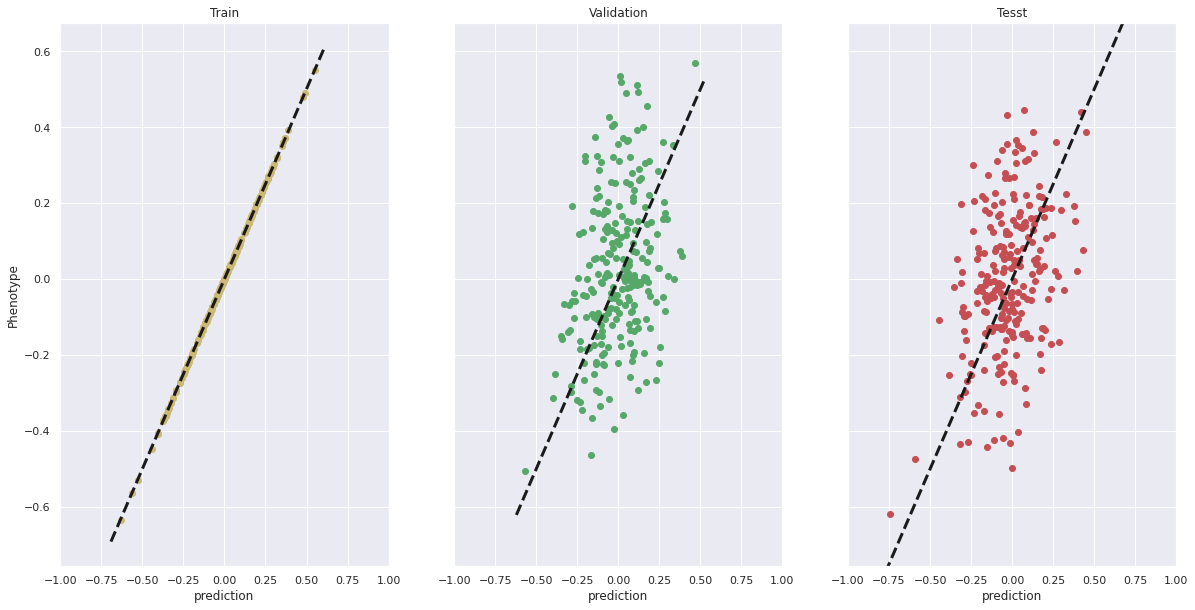

In [5]:
def simulate_phenotypes(given_genotypes, pis=(0.95, 0.05), gammas=np.array((0., 1.)), mixture_assignment=None):
    
    
    n, p = given_genotypes.shape
    if mixture_assignment is None:
      mixture_assignment = np.random.multinomial(1, pis, size=p)
    
    std_beta = 1
    
    betas = np.random.normal(loc=0.0,
                             scale=gammas[np.where(mixture_assignment)[1]]*std_beta,
                             size=p)
    
    mult = np.dot(given_genotypes, betas)
    g_var = np.var(mult, ddof=1)
    
    e = np.random.normal(0, np.sqrt(g_var), n)
    
    y = mult + e

    y -= np.mean(y)
    y /= np.var(y)
  
    return y, betas, mixture_assignment



test_genotypes = toy_genotypes[0:n,:]
val_genotypes = toy_genotypes[n:2*n,:]
train_genotypes = toy_genotypes[2 * n:,:]

if first:

    toy_phenotypes, betas, _ = simulate_phenotypes(toy_genotypes)
    test_phenotypes = toy_phenotypes[0:n,]
    val_phenotypes = toy_phenotypes[n:2*n,]
    train_phenotypes = toy_phenotypes[2 * n:,]

    savetxt('./betas.csv', betas, delimiter=',')

    savetxt('./train_genotypes.csv', train_genotypes, delimiter=',')
    savetxt('./train_phenotypes.csv', train_phenotypes, delimiter=',')

    savetxt('./test_genotypes.csv', test_genotypes, delimiter=',')
    savetxt('./test_phenotypes.csv', test_phenotypes, delimiter=',')

    savetxt('./val_genotypes.csv', val_genotypes, delimiter=',')
    savetxt('./val_phenotypes.csv', val_phenotypes, delimiter=',')

else:
    test_phenotypes, betas_test, grand_mixture = simulate_phenotypes(test_genotypes)
    val_phenotypes, betas_val,_ = simulate_phenotypes(val_genotypes, mixture_assignment=grand_mixture)
    train_phenotypes, betas_train,_ = simulate_phenotypes(train_genotypes, mixture_assignment=grand_mixture)

    savetxt('./train_genotypes.csv', train_genotypes, delimiter=',')
    savetxt('./train_phenotypes.csv', train_phenotypes, delimiter=',')
    savetxt('./betas_train.csv', betas_train, delimiter=',')

    savetxt('./test_genotypes.csv', test_genotypes, delimiter=',')
    savetxt('./test_phenotypes.csv', test_phenotypes, delimiter=',')
    savetxt('./betas_test.csv', betas_test, delimiter=',')

    savetxt('./val_genotypes.csv', val_genotypes, delimiter=',')
    savetxt('./val_phenotypes.csv', val_phenotypes, delimiter=',')
    savetxt('./betas_val.csv', betas_val, delimiter=',')


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

axis[0].hist(train_phenotypes, color='y', bins=30, alpha=0.5, histtype='stepfilled')
axis[0].set_title("Train")

axis[1].hist(val_phenotypes, color='g', bins=30, alpha=0.5, histtype='stepfilled')
axis[1].set_title("Validation")

axis[2].hist(test_phenotypes, color='r', bins=30, alpha=0.5, histtype='stepfilled')
axis[2].set_title("Tesst")

for ax in axis.flat:
    ax.set(ylabel='Freq')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('phenotypes_dist.pdf')

plt.plot(np.sort(val_phenotypes), color='g', label='val')
plt.plot(np.sort(test_phenotypes), color='r', label='test')
plt.plot(np.sort(train_phenotypes), color='y', label='train')
plt.legend(loc='upper left')
print("")
plt.savefig('phenotypes_dist_cont.pdf')
plt.show()

bins = np.linspace(-10, 10, 100)

plt.hist(train_phenotypes, bins, alpha=0.5, color='y', label='train')
plt.hist(test_phenotypes, bins, alpha=0.5, color='r', label='test')
plt.hist(val_phenotypes, bins, alpha=0.5, color='g', label='val')

plt.legend(loc='upper right')
plt.savefig('phenotypes_dist_together.pdf')
print("")
plt.show()

from sklearn import svm

reg = linear_model.Ridge(alpha=.5)
reg.fit(train_genotypes, train_phenotypes)


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

per = reg.predict(val_genotypes)

# plt.xticks(np.arange(-0.5, 0.5, 0.05))
# plt.yticks(np.arange(-0.5, 0.5, 0.01))

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)


RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')

del per

per = reg.predict(train_genotypes)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')

del per

per = reg.predict(test_genotypes)


axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.xlim(-1,1)
plt.show()
figure.savefig('linear_model_res.pdf')






In [6]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, phenotypes, batch_size=1):

        self.phenotypes = phenotypes
        self.genotype_matrix = genotype_matrix

        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]        
        samples = real_samples
        labels = self.phenotypes[idx, ]
        batch = {'x': samples, 'y': labels}

        return batch

    
    
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data    

dataset = Loader(train_genotypes, train_phenotypes)


from scipy.stats import gamma
alpha_gam = 2
beta_gam = 1

from scipy.stats import norm


def prior_sample(size=1):
    sigma = gamma.rvs(alpha_gam, scale=1/beta_gam, size=size)
    beta = norm.rvs(loc=0, scale=sigma, size=size)
    return beta, sigma

def prior_prob(beta, sigma):
    p_sig = gamma.pdf(sigma, alpha_gam, scale=1/beta_gam)
    p_beta = norm.pdf(beta, loc=0, scale=sigma)

    p_beta[np.where(np.isnan(p_beta))] = 1e-5
    
    return p_beta, p_sig


from scipy.stats import multivariate_normal

def metropolis_heisting(cur_beta, cur_sigma, cur_prob_theta, geno_mat, h_classifier):
    
#     changed_value = np.full(cur_theta_prob.shape, 1)
    counter = 0

    while(True):
        new_sigma = multivariate_normal(cur_sigma, var).rvs(size=1)
        new_beta = multivariate_normal(cur_beta, var).rvs(size=1)

        new_prior, _ = prior_prob(new_beta, new_sigma)
        new_ys = np.dot(geno_mat, new_beta)
        with torch.no_grad():
            r_value = h_classifier(new_ys, new_prior).cpu().detach().numpy()
            r_value = np.mean(r_value, axis=0)
            r_value = r_value / (1 - r_value)
            new_theta_prob = r_value * new_prior


            rho = (new_theta_prob) / (cur_prob_theta + 1e-7)
            rho[rho > 1] = 1
    #         rho = rho * changed_value
    #        rho = min(1, (new_theta_prob)/(cur_theta_prob))
            random_num = np.random.rand()
        
            if np.isnan(np.sum(rho)):
                print("EROR ------------------------")
                print(np.isnan(np.sum(cur_prob_theta)))
                print(np.isnan(np.sum(new_prob_theta)))

            if random_num < np.mean(rho):
                cur_beta = new_beta
                cur_sigma = new_sigma
                cur_theta_prob = new_theta_prob
                # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
                return cur_sigma, cur_beta, cur_theta_prob, new_ys

        counter += 1
        
        if counter > REP:
#             print("It Takes quite time :(")
            cur_beta = (new_beta + cur_beta) / 2
            cur_sigma = (new_sigma + cur_sigma) / 2
            cur_theta_prob = (new_theta_prob + cur_prob_theta) / 2
            # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
            return cur_sigma, cur_beta, cur_theta_prob, new_ys

class Classifier(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(Classifier, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        self.layer_1 = nn.Linear(input_dim, 1)
        self.layer_out = nn.Linear(2, 1)
        

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, beta, label=None):

        y = torch.Tensor(y).to(device)
        beta = torch.Tensor(beta).to(device)
        
        beta_summaries = self.layer_1(beta)
        x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries[None, :], y.shape[0], dim=0)], dim=1)
        x = self.layer_out(x)
        

        if label is not None:

            loss = self.criterion(x, label[:, None])
            return x, loss
        
        return x
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        self.layer_1 = nn.Linear(input_dim, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, beta, label=None):
        y = torch.Tensor(y).to(device)
        beta = torch.Tensor(beta).to(device)
        
        y = torch.repeat_interleave(y[:, None], d, dim=-1)
        beta = torch.repeat_interleave(beta[None, :], y.shape[0], dim=0)
        x = torch.cat([beta, y], dim=-1)
        
#         out = self.linear(x)
#         out = self.activation(out)
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        if label is not None:

            loss = self.criterion(x, label[:, None])
            return x, loss
        
        return x
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


Running on the CPU
1
504


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Best modedl changed
---------
Validation distance: 0.041861354438114416
EPOCH 0
Total Error tensor(22.9671, grad_fn=<AddBackward0>)


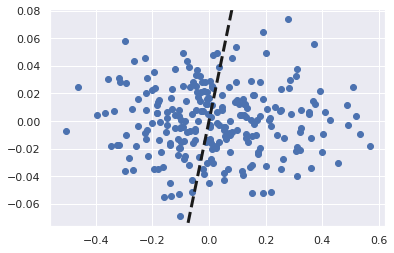

  0%|          | 2/500 [01:25<6:04:08, 43.87s/it]

Best modedl changed


  3%|▎         | 14/500 [10:11<6:24:39, 47.49s/it]

Best modedl changed


  3%|▎         | 15/500 [11:02<6:31:24, 48.42s/it]

Best modedl changed


  4%|▍         | 21/500 [15:50<6:35:42, 49.57s/it]

Best modedl changed


  6%|▋         | 32/500 [23:46<5:52:02, 45.13s/it]

Best modedl changed


  7%|▋         | 34/500 [25:13<5:49:30, 45.00s/it]

Best modedl changed


  8%|▊         | 38/500 [28:06<5:38:44, 43.99s/it]

Best modedl changed


  9%|▉         | 47/500 [34:28<5:14:58, 41.72s/it]

Best modedl changed


 10%|█         | 50/500 [36:52<5:51:00, 46.80s/it]

---------
Validation distance: 0.039938745062705595
EPOCH 50
Total Error tensor(18.9785, grad_fn=<AddBackward0>)


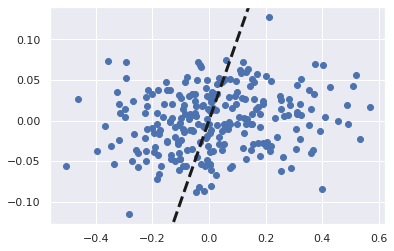

 12%|█▏        | 59/500 [43:12<5:35:32, 45.65s/it]

Best modedl changed


 17%|█▋        | 86/500 [1:03:00<5:24:13, 46.99s/it]

Best modedl changed


 20%|██        | 100/500 [1:13:56<5:11:11, 46.68s/it]

---------
Validation distance: 0.03971449680893546
EPOCH 100
Total Error tensor(20.2880, grad_fn=<AddBackward0>)


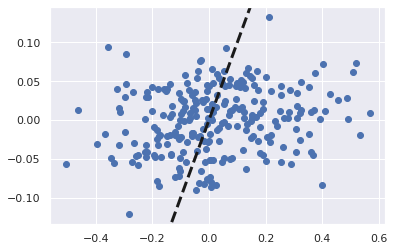

 21%|██        | 104/500 [1:16:48<4:50:27, 44.01s/it]

Best modedl changed


 25%|██▍       | 124/500 [1:31:17<4:39:35, 44.62s/it]

Best modedl changed


 28%|██▊       | 138/500 [1:41:54<4:45:38, 47.35s/it]

Best modedl changed


 29%|██▉       | 145/500 [1:47:16<4:30:04, 45.65s/it]

Best modedl changed


 30%|███       | 150/500 [1:51:22<4:32:04, 46.64s/it]

---------
Validation distance: 0.03825776689095407
EPOCH 150
Total Error tensor(20.1910, grad_fn=<AddBackward0>)


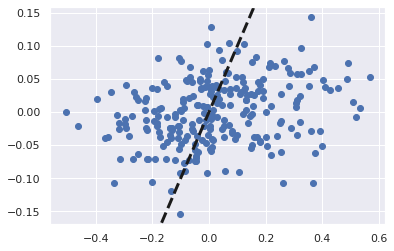

 40%|████      | 200/500 [2:27:45<3:51:16, 46.26s/it]

Best modedl changed
---------
Validation distance: 0.03806106269701721
EPOCH 200
Total Error tensor(20.6033, grad_fn=<AddBackward0>)


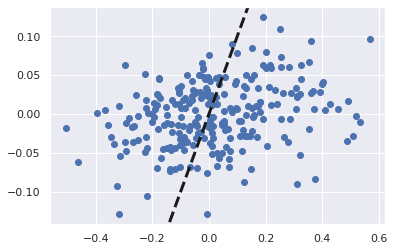

 50%|█████     | 250/500 [3:05:00<3:16:08, 47.07s/it]

Best modedl changed
---------
Validation distance: 0.03731140394971747
EPOCH 250
Total Error tensor(19.8037, grad_fn=<AddBackward0>)


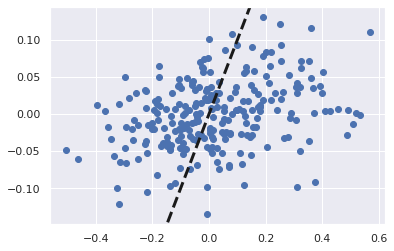

 60%|██████    | 300/500 [3:43:15<2:46:44, 50.02s/it]

---------
Validation distance: 0.03731140394971747
EPOCH 300
Total Error tensor(18.4494, grad_fn=<AddBackward0>)


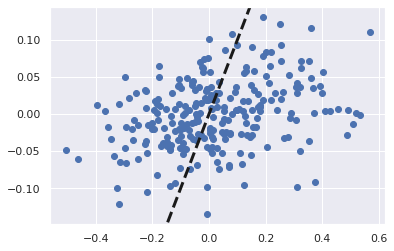

 70%|███████   | 350/500 [4:18:40<1:22:12, 32.88s/it]

---------
Validation distance: 0.03731140394971747
EPOCH 350
Total Error tensor(19.0124, grad_fn=<AddBackward0>)


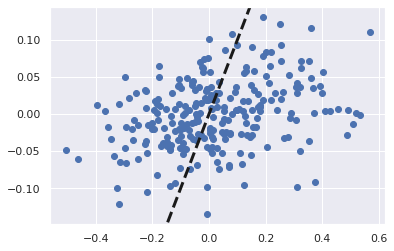

 80%|████████  | 400/500 [4:51:57<52:27, 31.48s/it]

---------
Validation distance: 0.03731140394971747
EPOCH 400
Total Error tensor(18.4259, grad_fn=<AddBackward0>)


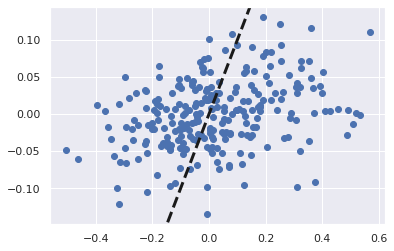

 82%|████████▏ | 410/500 [4:57:34<51:23, 34.26s/it]

Best modedl changed


 84%|████████▎ | 418/500 [5:02:33<55:22, 40.52s/it]

Best modedl changed


 90%|█████████ | 450/500 [5:22:18<28:54, 34.70s/it]

---------
Validation distance: 0.037000930551771616
EPOCH 450
Total Error tensor(17.8777, grad_fn=<AddBackward0>)


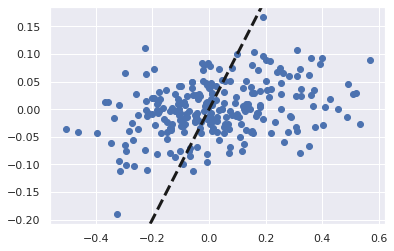

100%|██████████| 500/500 [5:55:58<00:00, 42.72s/it]


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

print(EPSILON)


data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)


if simple_model:
  classifier = Classifier(d).to(device)
else:
  classifier = LogisticRegression(d * 2).to(device)

print(classifier.get_n_params())

optimizer = optim.Adam(classifier
                         .parameters(), lr=0.0002)

losses = []
distances = []

denum = train_genotypes.shape[0] / BATCH_SIZE

losses = []


# Sampling beta
proper_beta_samples = []
proper_beta_samples_distances = []
counter = 0

RES_DICT['total_beta_sample'] = total_beta_sample


distance = -1


##### Saving
min_dist = 999
best_model = None

for epoch in tqdm(range(num_epochs)):
    
    error_sum = 0
    distance_sum = 0
    
#     var = np.eye(d) * (0.75 / (epoch + 1))
    var = np.eye(d) * 0.1

    cur_beta, cur_sigma = prior_sample(d)

    cur_ys = np.dot(train_genotypes, cur_beta)
    cur_ys -= np.mean(cur_ys)
    cur_ys /= np.var(cur_ys)
    cur_prior, _ = prior_prob(cur_beta, cur_sigma)
    cur_r_value = classifier(cur_ys, cur_beta).cpu().detach().numpy()
    cur_r_value = np.mean(cur_r_value, axis=0)
    cur_r_value = cur_r_value / (1 - cur_r_value)

    cur_theta_prob = cur_r_value * cur_prior

    proper_beta_samples_dist = {}

    for n_batch, batch in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        N = batch['x'].size(0)
        
        geno_batch = batch['x'].cpu().detach().numpy()
        pheno_batch = batch['y'].cpu().detach().numpy()
        
        sampled_sigma, sampled_beta, prob_theta, sampled_y = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
#         sampled_y = torch.sigmoid(torch.tensor(sampled_y)).numpy()
        
#         sampled_y = sampled_y
        sampled_y -= sampled_y.mean()
        sampled_y /= sampled_y.std()

        # sampled_y *= -1

        distance = np.mean((sampled_y - pheno_batch) ** 2)
        
#         print(distance)
        distance_sum += distance
        
        _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
        _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
        
#         _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
#         loss_f *= ((distance ** 2))
                             
#         _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
#         loss_r *= ((distance ** 2))
        
        loss = loss_f + loss_r
        loss *= (distance ** 2)

        loss += (lambda_val * np.sum(np.abs(sampled_beta)) / d)

        loss.backward()

        optimizer.step()
        error_sum += loss

        proper_beta_samples_dist[distance] = sampled_beta
            
        cur_beta = sampled_beta.copy()
        cur_sigma = sampled_sigma.copy()
        cur_theta_prob = prob_theta

    proper_beta_samples_val = np.array(proper_beta_samples)
    proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)
    
    if len(proper_beta_samples) > 0:
            # print("Using proper sets")
            proper_beta_samples_val = np.array(proper_beta_samples)
            proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)
            proper_beta_samples_val.shape

            val_y = np.dot(val_genotypes, proper_beta_samples_val)

    else:   
            val_y = np.dot(val_genotypes, sampled_beta)
  
    val_y -= np.mean(val_y)
    val_y /= np.var(val_y)

    val_distance = np.mean((val_y - val_phenotypes) ** 2)

    if min_dist > val_distance:
      min_dist = val_distance
      best_model = torch.save(classifier.state_dict(), "./best_modedl.pt")
      print("Best modedl changed")
    

    # Sampling beta based on validation datasets

    beta_validation_sample_dist = {}
    for _,samp_item in proper_beta_samples_dist.items():
      examine_val = np.dot(val_genotypes, samp_item)
      examine_val -= np.mean(examine_val)
      examine_val /= np.var(examine_val)

      examine_val_distance = np.mean((examine_val - val_phenotypes) ** 2)

      beta_validation_sample_dist[examine_val_distance] = samp_item
    
    items_sorted = sorted(beta_validation_sample_dist.keys(), reverse=True)

    if counter < total_beta_sample:
      empty = total_beta_sample - counter
      for i in range(empty):
        if i >= len(items_sorted):
          break
        # print(beta_validation_sample_dist[items_sorted[i]])
        proper_beta_samples.append(beta_validation_sample_dist[items_sorted[i]])
        proper_beta_samples_distances.append(items_sorted[i])
        counter += 1

    else:
      for dist_key in items_sorted:

        beta_value = beta_validation_sample_dist[dist_key]
        if dist_key < proper_beta_samples_distances[-1]:
          this_value_add = proper_beta_samples_distances[-1]
          counter_loop = total_beta_sample - 1
          while(dist_key < this_value_add):
            counter_loop -= 1
            if counter_loop < 0:
              proper_beta_samples.insert(0,beta_value)
              proper_beta_samples.pop(-1)
              proper_beta_samples_distances.insert(0, dist_key)
              proper_beta_samples_distances.pop(-1)
              break
            if proper_beta_samples_distances[counter_loop] < dist_key:
              proper_beta_samples.insert(counter_loop + 1, beta_value)
              proper_beta_samples.pop(-1)
              proper_beta_samples_distances.insert(counter_loop + 1, dist_key)
              proper_beta_samples_distances.pop(-1)
              break
          else:
            break
    
    if (epoch % int(num_epochs / 10) == 0 and epoch >= int(num_epochs / 10)) or epoch == 0:
        print("---------")
        print("Validation distance:", val_distance)
        print("EPOCH", epoch)
        print("Total Error", error_sum)


        plt.scatter(val_phenotypes, val_y)
        xpoints = ypoints = plt.xlim()
        plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
        plt.show()
#     print(distance_sum / denum)
        
    losses.append([error_sum / denum])
    distances.append([distance_sum / denum])
        

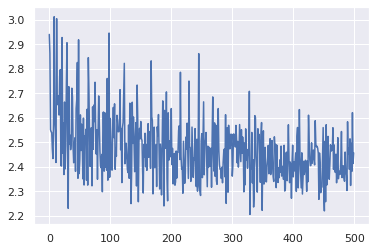

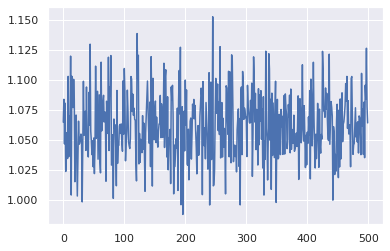

1.061793802238902


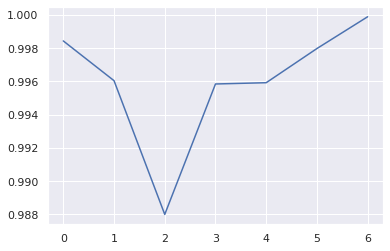

In [8]:
plt.plot(np.arange(epoch + 1), losses)
plt.show()
plt.plot(np.arange(epoch + 1), distances)
plt.show()
distances = np.array(distances)
plt.plot(np.arange(len(distances[distances < EPSILON])), distances[distances < EPSILON])
print(np.mean(distances))
plt.show()

(20, 500)
(500,)
34


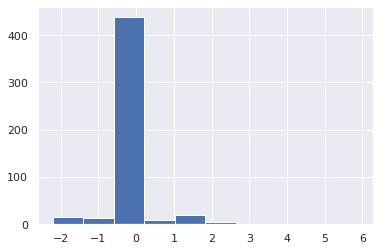

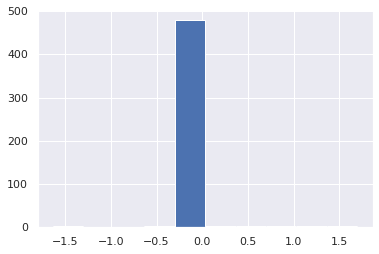

In [9]:
savetxt('./betas_sample.csv', proper_beta_samples, delimiter=',')

proper_beta_samples_np = np.array(proper_beta_samples).T

# proper_beta_samples_np -= np.mean(proper_beta_samples_np, axis=1)
# proper_beta_samples_np /= np.var(proper_beta_samples_np, axis=1)

print(proper_beta_samples_np.T.shape)
proper_beta_samples_mean = np.mean(proper_beta_samples_np.T, axis=0)
print(proper_beta_samples_mean.shape)

proper_beta_samples_mean -= np.mean(proper_beta_samples_mean)
proper_beta_samples_mean /= np.var(proper_beta_samples_mean)
proper_beta_samples_mean[np.abs(proper_beta_samples_mean) < 0.9] = 0
print(len(proper_beta_samples_mean[proper_beta_samples_mean > 0]))

if first:
    plt.hist(proper_beta_samples_mean)
    plt.show()
    plt.hist(betas)
    plt.show()
else:
    plt.hist(proper_beta_samples_mean)
    plt.show()
    plt.hist(betas_train)
    plt.show()


15
(20,)


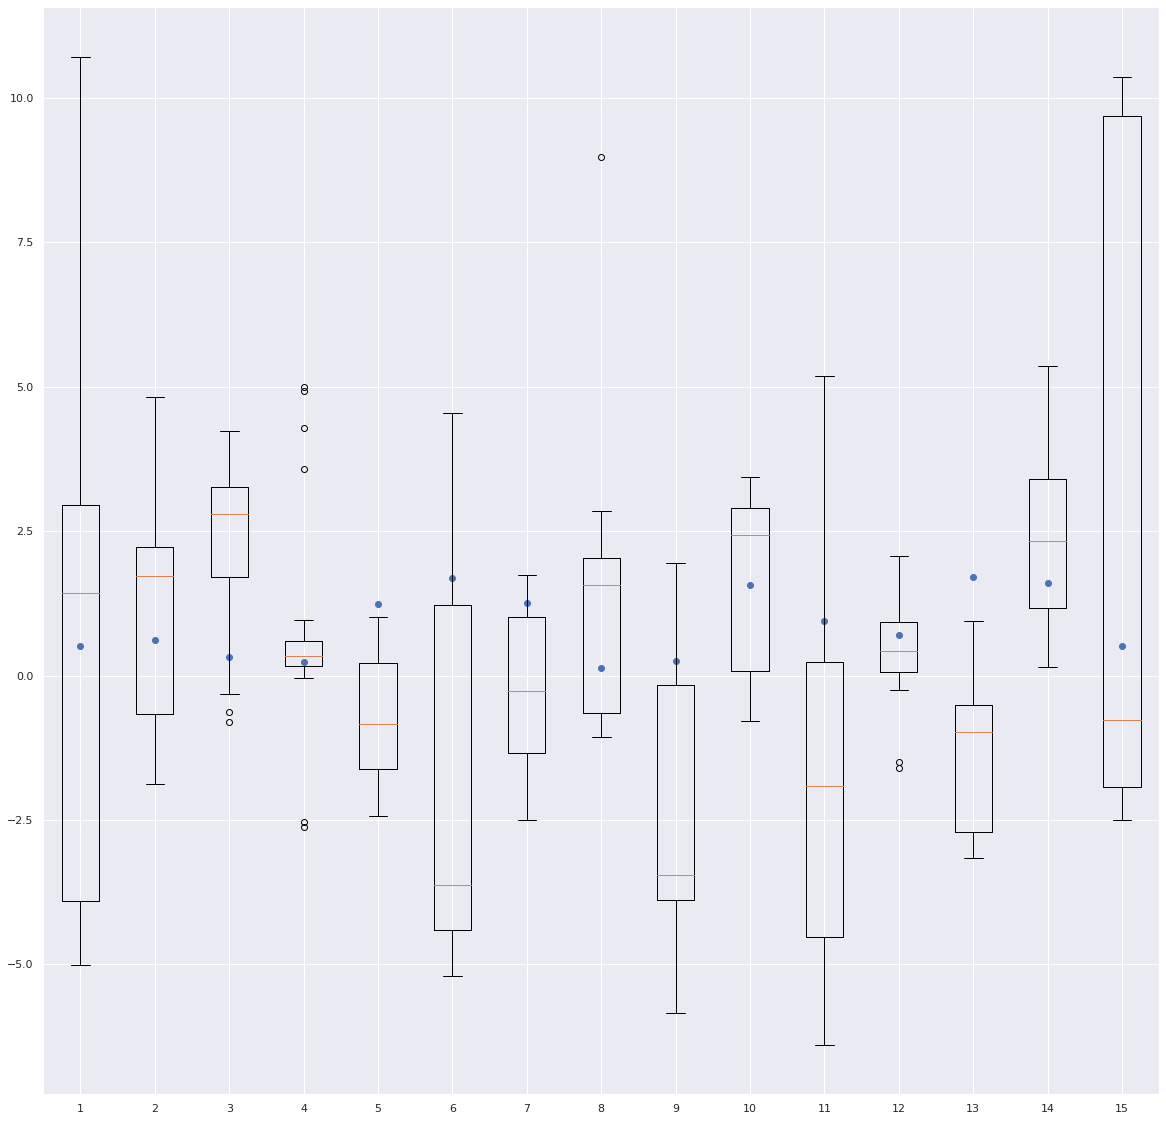

7
(20,)


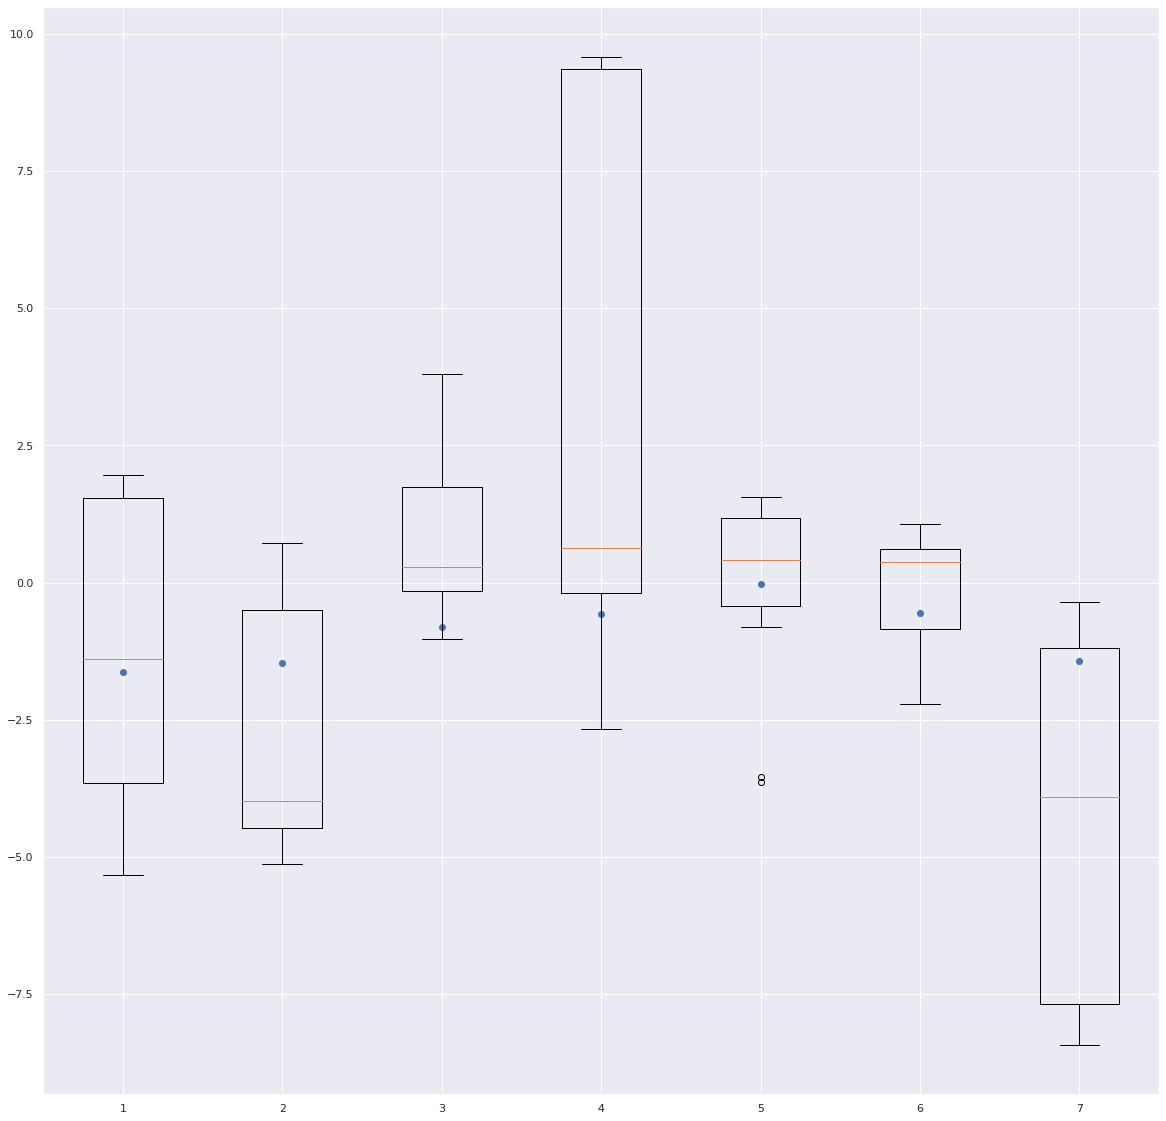

22
(20,)


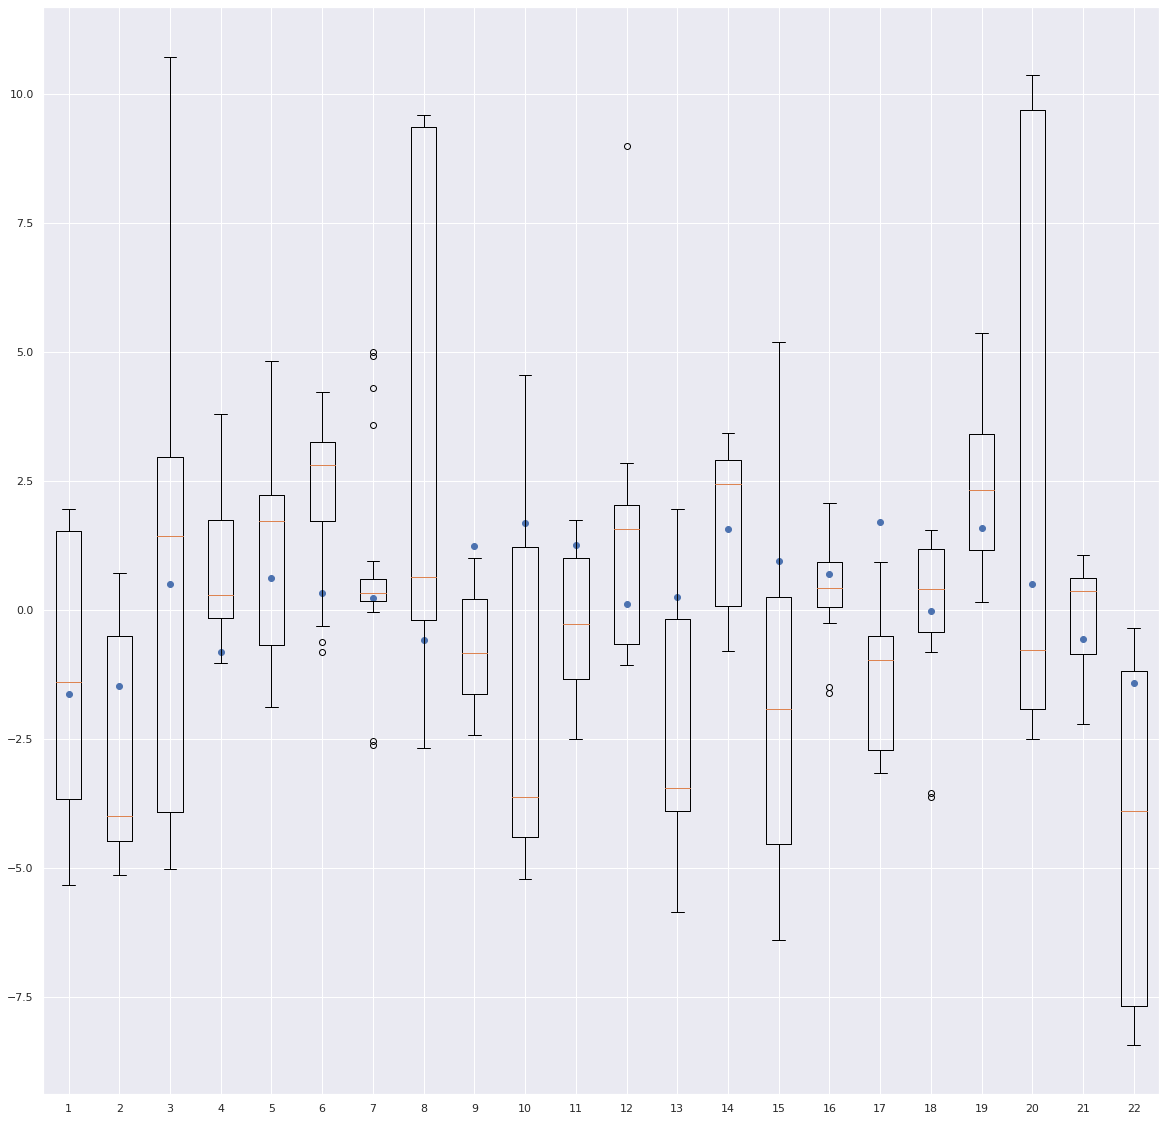

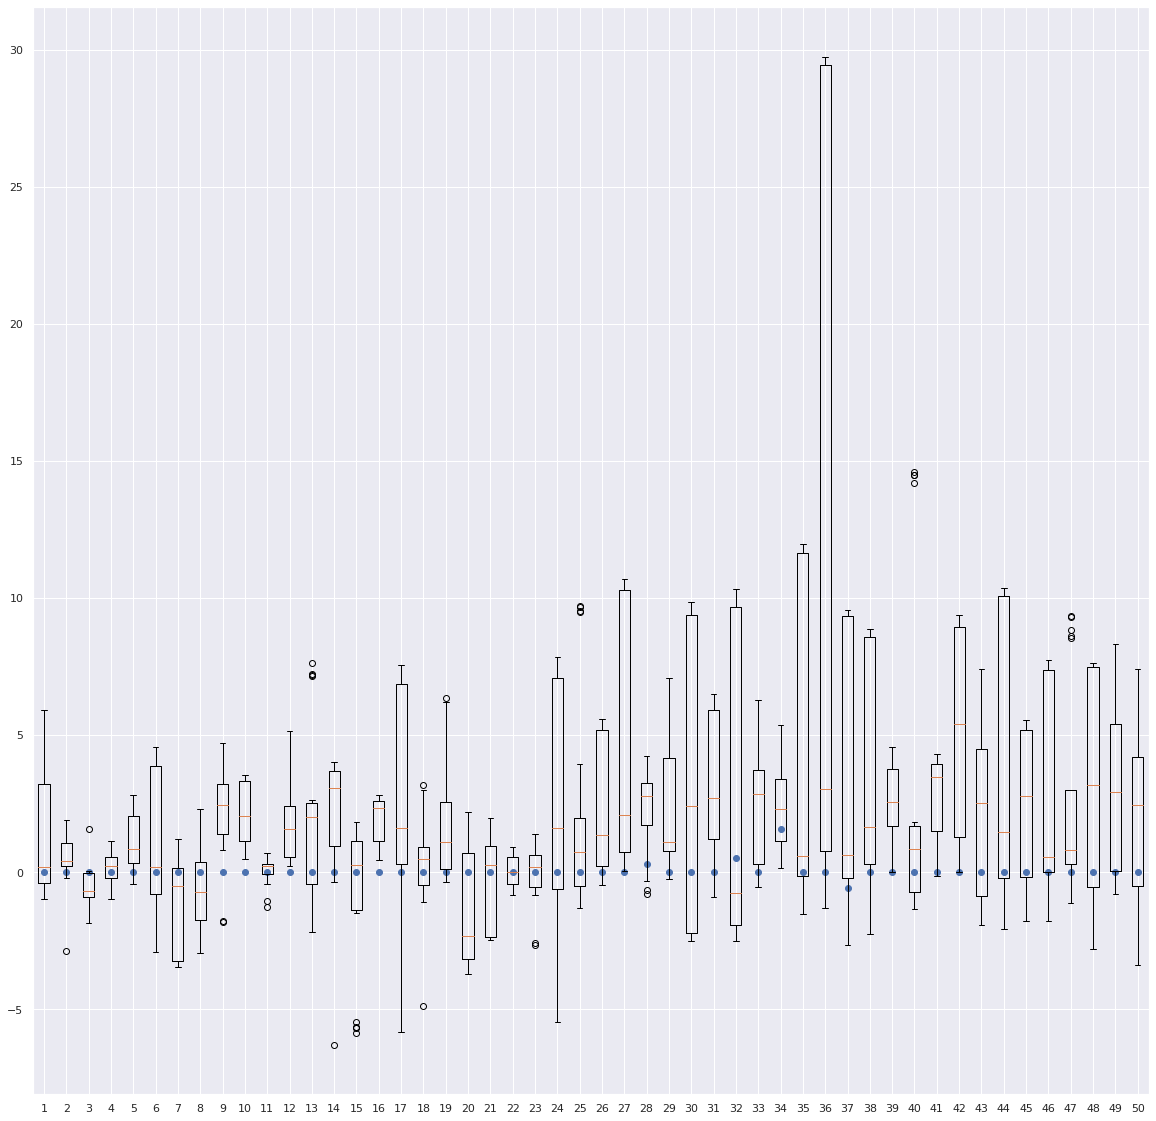

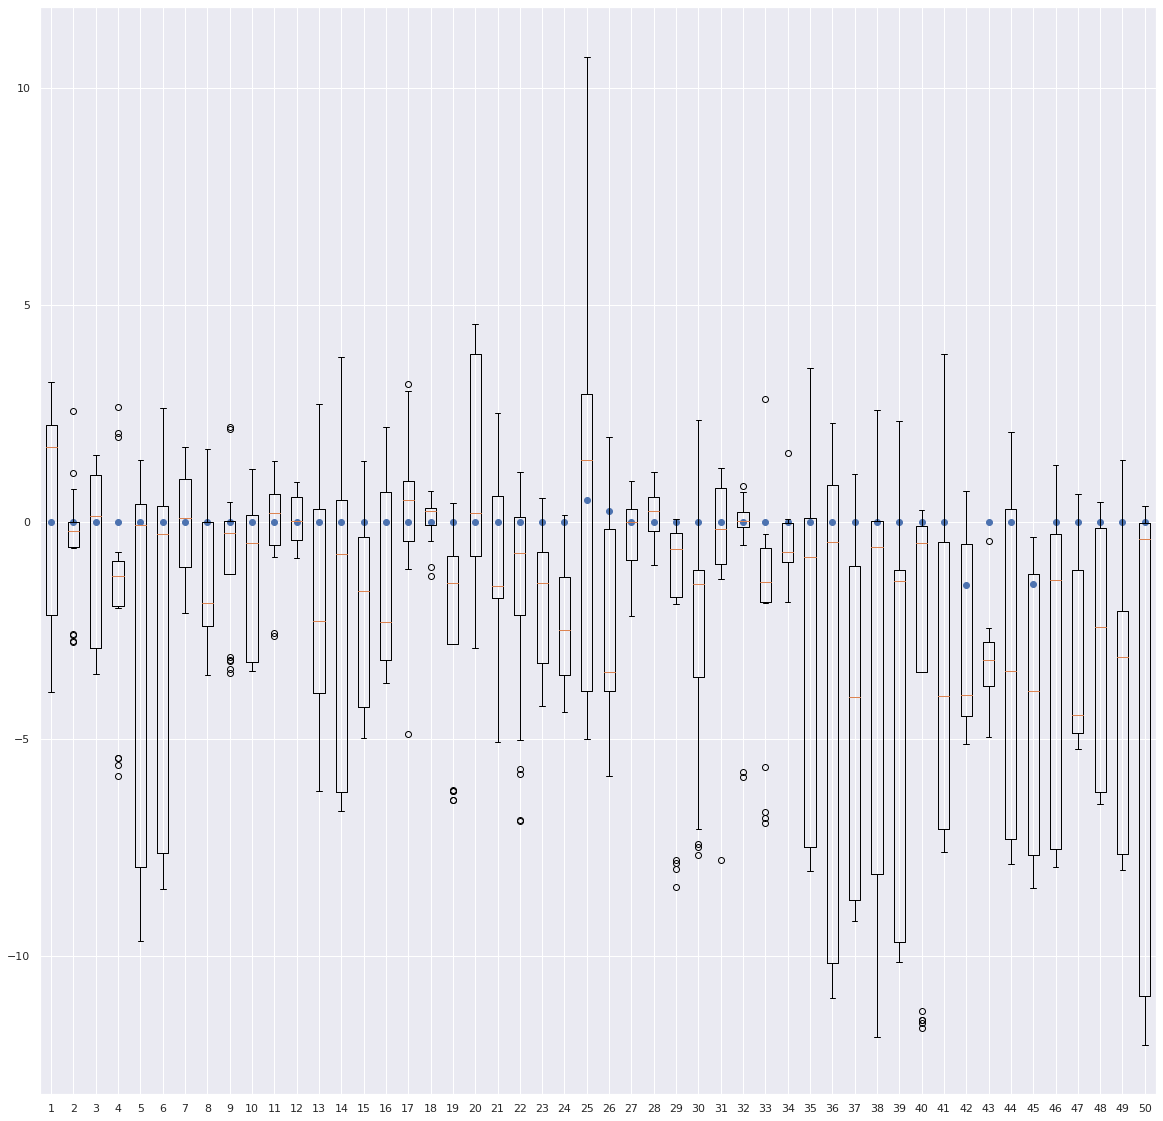

In [10]:
show_case = 50
threshold_filtering = 0.6

if first:

    to_plot = []
    for i in range(proper_beta_samples_np[betas > 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas > 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas[betas > 0])
    fig.savefig('boxplot_original_betas_greater_than_zero.pdf',bbox_inches='tight')
    plt.show()

    to_plot = []
    for i in range(proper_beta_samples_np[betas < 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas < 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas[betas < 0])
    fig.savefig('boxplot_original_betas_lower_than_zero.pdf',bbox_inches='tight')
    plt.show()


    to_plot = []
    for i in range(proper_beta_samples_np[betas != 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas != 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas[betas!=0])
    fig.savefig('boxplot_original_betas_non_zero.pdf',bbox_inches='tight')
    plt.show()



    # to_plot = []
    # for i in range(proper_beta_samples_np[proper_beta_samples_mean > threshold_filtering].shape[0]):
    #     to_plot += [proper_beta_samples_np[proper_beta_samples_mean > threshold_filtering][i, :]]

    # print(len(to_plot))
    # print(to_plot[0].shape)
    # fig=plt.figure(1,figsize=(20,20))
    # ax=fig.add_subplot(111)
    # bp=ax.boxplot(to_plot)

    # plt.scatter(np.arange(len(to_plot)) + 1, betas[proper_beta_samples_mean > threshold_filtering])
    # fig.savefig('boxplot_predicted_betas_greater_than_zero.pdf',bbox_inches='tight')
    # plt.show()


    # ind = np.argpartition(np.abs(proper_beta_samples_mean), -int(show_case))[-int(show_case):]
    ind = np.argpartition(proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas[ind])
    fig.savefig('boxplot_greatest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


    ind = np.argpartition(-1 * proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas[ind])
    fig.savefig('boxplot_lowest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


else:
    to_plot = []
    for i in range(proper_beta_samples_np[betas_train > 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas_train > 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas_train[betas_train > 0])
    fig.savefig('boxplot_original_betas_greater_than_zero.pdf',bbox_inches='tight')
    plt.show()

    to_plot = []
    for i in range(proper_beta_samples_np[betas_train < 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas_train < 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas_train[betas_train < 0])
    fig.savefig('boxplot_original_betas_lower_than_zero.pdf',bbox_inches='tight')
    plt.show()


    to_plot = []
    for i in range(proper_beta_samples_np[betas_train != 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas_train != 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas_train[betas_train!=0])
    fig.savefig('boxplot_original_betas_non_zero.pdf',bbox_inches='tight')
    plt.show()


    # ind = np.argpartition(np.abs(proper_beta_samples_mean), -int(show_case))[-int(show_case):]
    ind = np.argpartition(proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas_train[ind])
    fig.savefig('boxplot_greatest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


    ind = np.argpartition(-1 * proper_beta_samples_mean, -int(show_case))[-int(show_case):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas_train[ind])
    fig.savefig('boxplot_lowest_values_predicted_betas.pdf',bbox_inches='tight')
    plt.show()


0.0371245350219129 validation
0.04749654808283107 train
0.04519465078886383 test


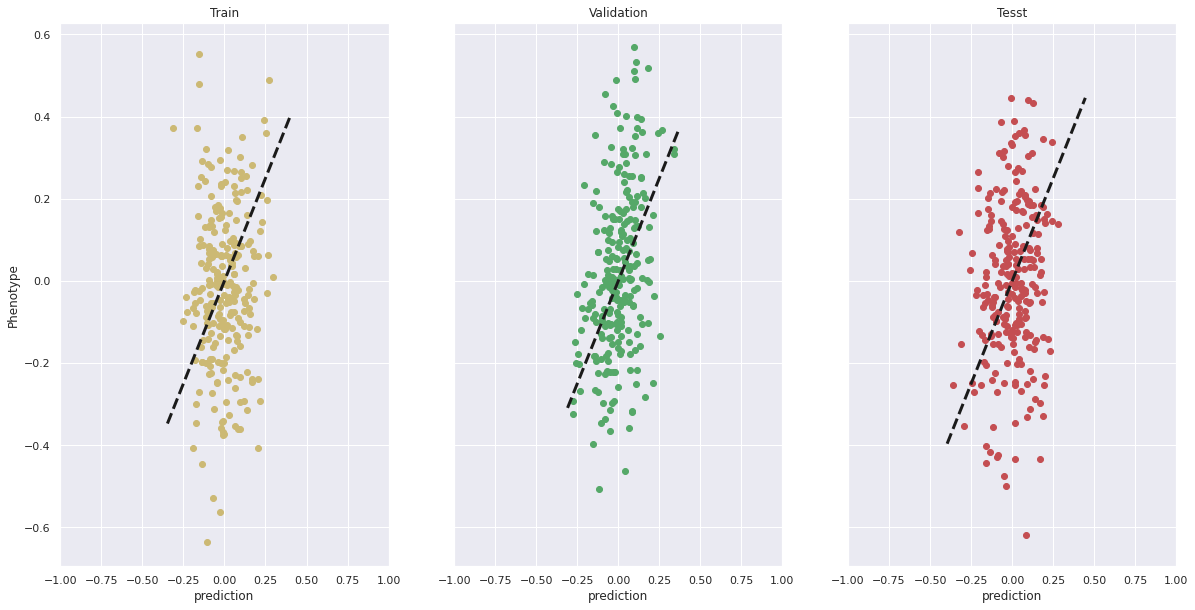

0.20034904498049408


In [11]:
figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

# del per
per = np.dot(val_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')

del per

per = np.dot(train_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')

del per

per = np.dot(test_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

plt.xlim(-1,1)
plt.show()
figure.savefig('proposed_model_res.pdf')


if first:
    print(np.mean(np.abs(proper_beta_samples_mean - betas)))
else:
    print(np.mean(np.abs(proper_beta_samples_mean - betas_train)))
    print(np.mean(np.abs(proper_beta_samples_mean - betas_test)))
    print(np.mean(np.abs(proper_beta_samples_mean - betas_val)))


In [12]:
import pickle
    
try:
    res_file = open('res_dict', 'wb')
    pickle.dump(RES_DICT, res_file)
    res_file.close()
  
except:
    print("Something went wrong")